# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
from scipy.optimize.minpack import curve_fit
from scipy import stats
%matplotlib inline

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

In [2]:
#sample initial conditions
Toi = 0.0
Tai = 0.0

# model parameters, variables and functions
tune = 0.10          #model tuning parameter
Coo = -1.00 * tune
Coa = +1.00 * tune
Cao = +0.10 * tune
Caa = -1.00 * tune
m = 10.0

# time series
t_start = 0.0
t_end = 1000.0
time_samples = 1000
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = 0.5     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def func(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta + (A * np.sin((2*mt.pi*t)/P))
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

In [3]:
# solve ODEs
x0 = [Toi, Tai]
A        = 1.00 * 1.0                #relative amplitude of periodic forcing
P        = 20.0/(2 * mt.pi)          #period of periodic forcing
P        = 2 * mt.pi * P
soln = odeint(func,x0,t)
To = soln[:,0]
Ta = soln[:,1]

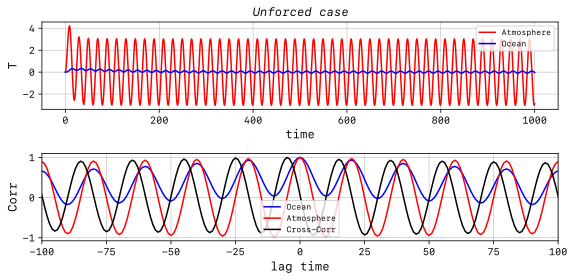

In [4]:
#plot results
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(8,4),dpi=120);
plt.subplot(2, 1, 1)
plt.xlabel('time',fontproperties=font,fontsize=12)
plt.ylabel('T',fontproperties=font,fontsize=12)
plt.plot(t,Ta,'r',t,To,'b')
ax = gca(); ticks(ax,10); ax.set_title('Unforced case',fontproperties=fontit,fontsize=12);
plt.gca().legend(('Atmosphere','Ocean'),prop=prop);
plt.grid(linewidth=0.5); ax.set_axisbelow(True)

[lag_time_To, autocorr_To] = autocorr(To,t)
[lag_time_Ta, autocorr_Ta] = autocorr(Ta,t)
[lag_time_T, crosscorr_T] = crosscorr(Ta,To,t)

plt.subplot(2, 1, 2)
plt.plot(lag_time_To,autocorr_To/float(autocorr_To.max()),'b',lag_time_Ta,autocorr_Ta/float(autocorr_Ta.max()),'r',lag_time_T,crosscorr_T/float(abs(crosscorr_T).max()),'k')
plt.xlabel('lag time',fontproperties=font,fontsize=12)
plt.ylabel('Corr',fontproperties=font,fontsize=12)
ax = gca(); ticks(ax,10)
plt.gca().legend(('Ocean','Atmosphere','Cross-Corr'),prop=prop);
plt.tight_layout(); 
plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.set_xlim([-100, 100]);

In the presence of the stochastic forcing term(s), one must find alternative ways to solve the coupled ODEs as <font color='red'>scipy.integrate.odeint()</font> wouldn't work in this case. We use <font color='blue'>sdeint()</font> in this case.

In [5]:
import sdeint

# define forcing function (weiner process with <cross-section>)
crosssec = 1.00 * 1.0  #relative amplitude of stochastic forcing

# set white noise forcing amplitude
W = np.diag([0.0, crosssec])

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforcp(x, t):
    return C.dot(x) + np.array([0.0, (A * np.sin((2*mt.pi*t)/P))])

def unforc(x, t):
    return C.dot(x)

def forc(x, t):
    return W

def norm_fit(x,y):
    mu, std = stats.norm.fit(y)
    smoothx = np.linspace(x[0], x[-1], 500)
    best_fit = stats.norm.pdf(smoothx, mu, std)
    return smoothx, best_fit

def norm_fit_params(x,y):
    mu, std = stats.norm.fit(y)
    return mu, std

def skewnorm_fit(x,y):
    ae, loce, scalee = stats.skewnorm.fit(y)
    smoothx = np.linspace(x[0], x[-1], 500)
    best_fit = stats.skewnorm.pdf(smoothx,ae,loce,scalee)
    return smoothx, best_fit, ae, loce, scalee

soln = sdeint.itoint(unforcp,forc,x0,t)
To = soln[:,0]
Ta = soln[:,1]

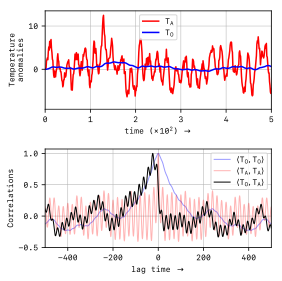

In [16]:
#plot results
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(4,4),dpi=200);
plt.subplot(2, 1, 1)
plt.xlabel(r'time $\mathregular{(\times\,10^2)}\;\;\rightarrow$',fontproperties=font,fontsize=8)
plt.ylabel(r'Temperature' '\n' r'anomalies',fontproperties=font,fontsize=8)
plt.plot(t/100,Ta,'r',t/100,To,'b')
ax = gca(); ticks(ax,8); #ax.set_title('Forced case',fontproperties=fontit,fontsize=12);
plt.gca().legend((r'$\mathregular{T_A}$',r'$\mathregular{T_O}$'),prop=prop,loc='upper center');
plt.grid(linewidth=0.5); ax.set_axisbelow(True)
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_xlim([0, 5]);

[lag_time_To, autocorr_To] = autocorr(To,t)
[lag_time_Ta, autocorr_Ta] = autocorr(Ta,t)
[lag_time_T, crosscorr_T] = crosscorr(Ta,To,t)

plt.subplot(2, 1, 2)
plt.plot(lag_time_To,autocorr_To/float(autocorr_To.max()),     'b',linewidth=1.0,alpha=0.4)
plt.plot(lag_time_Ta,autocorr_Ta/float(autocorr_Ta.max()),     'r',linewidth=1.0,alpha=0.3)
plt.plot(lag_time_T, crosscorr_T/float(abs(crosscorr_T).max()),'k',linewidth=1.0,alpha=1.0)
plt.xlabel(r'lag time $\rightarrow$',fontproperties=font,fontsize=8)
plt.ylabel('Correlations',fontproperties=font,fontsize=8)
ax = gca(); ticks(ax,8)
plt.gca().legend((r'$\langle\mathregular{T_O},\mathregular{T_O}\rangle$',r'$\langle\mathregular{T_A},\mathregular{T_A}\rangle$',r'$\langle\mathregular{T_O},\mathregular{T_A}\rangle$'),prop=prop);
plt.tight_layout();
plt.grid(linewidth=0.5); ax.set_axisbelow(True)
ax.set_xlim([-500, 500]); ax.set_ylim([-0.5, None]);

#plt.savefig("/Users/asi066/Desktop/Fig1r.png",dpi=800)

In [7]:
# get lags corresponding to cross-correlation threshold
import bisect
def nearest(x, d):
    index = bisect.bisect(d, x)
    if not index:
        return d[index]  #left-most x coordinate
    if index == len(d):
        return d[-1]     #right-most x coordinate
    return min(d[index - 1:index + 1], key=lambda v: abs(v - x))

corr_cut = 0.5    #threshold on correlation
lag_cut  = 100.0  #ignore all lags larger than some value

We are able to reproduce the asymmetry in cross-correlation between oceanic and atmospheric states. This asymmetry is a function of the initial temperature anomalies and the forcing function $\mathsf{F}$. 



# Variance in peak cross-correlation

In order to quantify to variance in peak cross-correlation, we run an experiment where a distribution of initial conditions is considered. 

In [8]:
#solve the system of ODEs with a sample set of initial conditions
samples = 200
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere
peak_corr = []
To_l = []; Ta_l = []
time_ignore = int(np.floor(time_stable*len(t)))                #ignore fraction of preceding analysis 

#calculate trajectories for all samples
VecCorr = []; LagCorr = []; CutCorr = []; CountIgnore = 0; Multi = []; meanO = []; stdO = []; meanA = []; stdA = []
for i in range(samples):
    #x0 = [rand.uniform(-Toi_lim, Toi_lim), rand.uniform(-Tai_lim, Tai_lim)]
    x0 = [Toi, Tai]
    soln = sdeint.itoint(unforc,forc,x0,t)
    To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
    Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
    meanO.append(np.mean(To_t[time_ignore:])); meanA.append(np.mean(Ta_t[time_ignore:]))
    stdO.append(np.std(To_t[time_ignore:])); stdA.append(np.std(Ta_t[time_ignore:]))
    [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
    crosscor = [j/float(abs(crosscor.max())) for j in crosscor]
    VecCorr.append(np.abs(crosscor)); LagCorr.append(lag_time)
    max_index = np.argmax(crosscor)
    peak_corr.append(abs(lag_time[max_index]))
    #get cut point on correlations
    y        = [i - corr_cut for i in crosscor] 
    ind      = y.index(nearest(0.0, y))
    lag_opt  = abs(lag_time[ind])
    if lag_opt <= lag_cut:
        CutCorr.append(lag_opt)
        if abs(lag_time[max_index]) > 0:
            Multi.append(lag_opt/(abs(lag_time[max_index])))
        else:
            Multi.append(0.0)    
    else:
        CutCorr.append(np.float('nan'))
        Multi.append(np.float('nan'))
        CountIgnore = CountIgnore + 1

CorrTraj = []; CorrTrajMax = []
for item in np.arange(0, samples):
    CorrTraj.append(VecCorr[item]/np.max(abs(VecCorr[item])))
    CorrTrajMax.append(max(VecCorr[item]/np.max(abs(VecCorr[item]))))

mean_oce = np.mean(meanO); std_oce = np.mean(stdO)
mean_atm = np.mean(meanA); std_atm = np.mean(stdA)

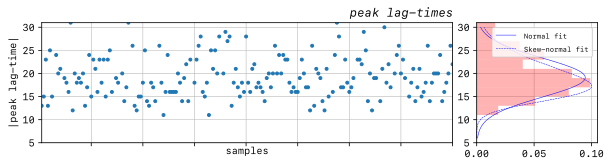

In [9]:
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'

binwidth = 2.0; bin_off = 0.00;
bins = np.arange(5 - bin_off, 30 + binwidth + bin_off, binwidth)
binp = (bins[1:] + bins[:-1]) / 2
       
#plot cross-corr statistics vs lag-times
fig = plt.figure(figsize=(10,3), dpi=100);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.plot(np.arange(1, samples + 1), np.abs(peak_corr),linewidth=0.0, marker='.')
ax_marg_y.hist(np.abs(peak_corr),orientation="horizontal",alpha=0.3, density=True, edgecolor='black', linewidth=0.00, bins = bins, facecolor='red')
peak_corr0 = []
for val in np.abs(peak_corr):
    if bins[0] < val < bins[-1]:
        peak_corr0.append(val)
smoothx, best_fit = norm_fit(binp, np.abs(peak_corr0))
mu, std           = norm_fit_params(binp, np.abs(peak_corr0))
x, y, a, m, s     = skewnorm_fit(binp, np.abs(peak_corr0))
ax_marg_y.plot(best_fit, smoothx,'-b', linewidth=0.5)
ax_marg_y.plot(y, x,'--b', linewidth=0.5)
ticks(ax_joint,10); ticks(ax_marg_y,10); 
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)
#l1 = ax_marg_y.legend(['G[' + str("{:.1f}".format(mu)) + ', ' + str("{:.1f}".format(std)) + ']', 'S[' + str("{:.1f}".format(a)) + ', ' + str("{:.1f}".format(m)) + ', ' + str("{:.1f}".format(s)) + ']'], loc='upper right', ncol=1)
l1 = ax_marg_y.legend(['Normal fit','Skew-normal fit'], loc='upper right', ncol=1)
plt.setp(l1.texts, family='SF Mono', fontsize=7);
plt.setp(ax_joint.get_xticklabels(), visible=False)

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=True)
plt.setp(ax_marg_y.get_xticklabels(), visible=True)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);
ax_joint.set_ylim([bins[0], bins[-1]]); ax_marg_y.set_ylim([bins[0], bins[-1]]); 

# Set labels on joint
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=10)
ax_joint.set_ylabel('|peak lag-time|',fontproperties=font,fontsize=10);
ax_joint.set_title('peak lag-times',fontproperties=fontit,fontsize=12, loc='right');
#plt.savefig("/Users/asi066/Desktop/Fig4d.png",dpi=800)

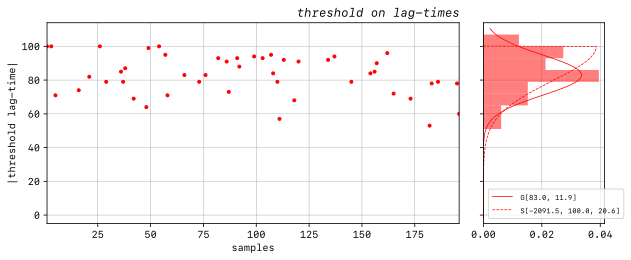

In [10]:
#plot cross-corr threshold vs lag-times
import warnings
warnings.filterwarnings("ignore")

binwidth = 7; bin_off = 10.0;
bins = np.arange(5 - bin_off, 100 + binwidth + bin_off, binwidth)
binp = (bins[1:] + bins[:-1]) / 2

fig = plt.figure(figsize=(10,5), dpi=100);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.plot(np.arange(1, samples + 1), np.abs(CutCorr), 'r',linewidth=0.0, marker='.')
ax_marg_y.hist(np.abs(CutCorr),orientation="horizontal",alpha=0.5, density=True, facecolor='r', edgecolor='black', linewidth=0.00, bins = bins)
CutCorr2 = [value for value in CutCorr if not mt.isnan(value)]
smoothx, best_fit = norm_fit(binp, CutCorr2)
mu, std           = norm_fit_params(binp, np.abs(CutCorr2))
x, y, a, m, s     = skewnorm_fit(binp, np.abs(CutCorr2))
ax_marg_y.plot(best_fit, smoothx,'-r', linewidth=0.75)
ax_marg_y.plot(y, x,'--r', linewidth=0.75)
ticks(ax_joint,10); ticks(ax_marg_y,10); 
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)
l1 = ax_marg_y.legend(['G[' + str("{:.1f}".format(mu)) + ', ' + str("{:.1f}".format(std)) + ']', 'S[' + str("{:.1f}".format(a)) + ', ' + str("{:.1f}".format(m)) + ', ' + str("{:.1f}".format(s)) + ']'], loc='best', ncol=1)
plt.setp(l1.texts, family='SF Mono', fontsize=7);

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.setp(ax_marg_y.get_xticklabels(), visible=True)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);
ax_joint.set_ylim([bins[0], bins[-1]]); ax_marg_y.set_ylim([bins[0], bins[-1]]); 

# Set labels on joint
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=10)
ax_joint.set_ylabel('|threshold lag-time|',fontproperties=font,fontsize=10);
ax_joint.set_title('threshold on lag-times',fontproperties=fontit,fontsize=12, loc='right');

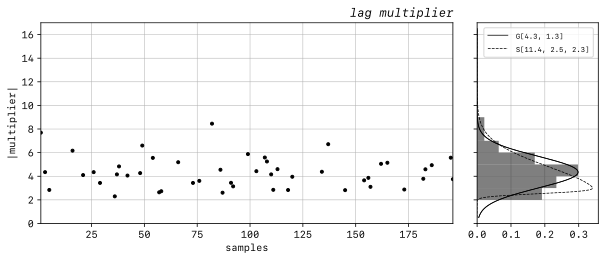

In [11]:
#plot Multiplier vs lag-times
import warnings
warnings.filterwarnings("ignore")

binwidth = 1.0; bin_off = 2.0;
bins = np.arange(2 - bin_off, 15 + binwidth + bin_off, binwidth)
binp = (bins[1:] + bins[:-1]) / 2

fig = plt.figure(figsize=(10,5), dpi=100);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.plot(np.arange(1, samples + 1), np.abs(Multi), 'k',linewidth=0.0, marker='.')
ax_marg_y.hist(np.abs(Multi),orientation="horizontal",alpha=0.5, density=True, facecolor='k', edgecolor='black', linewidth=0.00, bins = bins)
Multi2 = [value for value in Multi if not mt.isnan(value)]
smoothx, best_fit = norm_fit(binp, Multi2)
mu, std           = norm_fit_params(binp, np.abs(Multi2))
x, y, a, m, s     = skewnorm_fit(binp, np.abs(Multi2))
ax_marg_y.plot(best_fit, smoothx,'-k', linewidth=0.75)
ax_marg_y.plot(y, x,'--k', linewidth=0.75)
ax_marg_y.plot(best_fit, smoothx,'-k', linewidth=0.75)
ticks(ax_joint,10); ticks(ax_marg_y,10); 
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)
l1 = ax_marg_y.legend(['G[' + str("{:.1f}".format(mu)) + ', ' + str("{:.1f}".format(std)) + ']', 'S[' + str("{:.1f}".format(a)) + ', ' + str("{:.1f}".format(m)) + ', ' + str("{:.1f}".format(s)) + ']'], loc='best', ncol=1)
plt.setp(l1.texts, family='SF Mono', fontsize=7);

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.setp(ax_marg_y.get_xticklabels(), visible=True)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);
ax_joint.set_ylim([bins[0], bins[-1]]); ax_marg_y.set_ylim([bins[0], bins[-1]]);

# Set labels on joint
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=10)
ax_joint.set_ylabel('|multiplier|',fontproperties=font,fontsize=10);
ax_joint.set_title('lag multiplier',fontproperties=fontit,fontsize=12, loc='right');

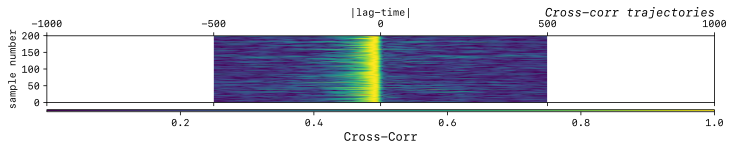

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
from matplotlib.colors import LogNorm
%config InlineBackend.figure_format = 'svg'

CorrTrajRaw = CorrTraj; CorrTraj = []
for row in CorrTrajRaw:
    row_new = []
    for index in arange(t_start,t_end):
        row_new.append(row[int(index/resolution)])
            
    CorrTraj.append(row_new) 

#draw trajectories of Cross-Corr for 50 samples
fig, ax = plt.subplots(figsize=(12,12), dpi=200);
im = ax.matshow(np.array(CorrTraj),origin='lower');
ax.grid(which='minor')
ax.set_aspect(1.0)
ax.set_xlim([(t[-1] - t[0])/2 - 1000, (t[-1] - t[0])/2 + 1000]);

#colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad = 0.1)
cb = plt.colorbar(im, cax=cax,label='Cross-Corr',orientation="horizontal");
axc = cb.ax
text = axc.xaxis.label
text.set_font_properties(proplr)
ticks(axc,10);

ax.set_ylabel('sample number',fontproperties=font,fontsize=10); 
ax.xaxis.set_label_position('top');
ax.set_xlabel('|lag-time|',fontproperties=font,fontsize=10); 
xlabels = ax.get_xticks().tolist()
xlabels_lag = [int(item - max(LagCorr[-1])) for item in xlabels]
ax.set_xticklabels(xlabels_lag)

ticks(ax,10);
ax.set_title('Cross-corr trajectories',fontproperties=fontit,fontsize=12, y=1.2, loc='right');


# Climatological errors

## Stochastic

### Amplitude: 1.00

$\sigma_{_\mathsf{T_O}} = $ 0.64,
$\sigma_{_\mathsf{T_A}} = $ 2.40


In [13]:
#print(mean_oce, std_oce, mean_atm, std_atm)